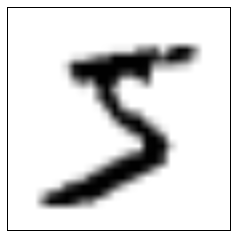

In [9]:
import base64
import json
import numpy as np
from pyspark.mllib.clustering import KMeans
from __future__ import division
import matplotlib.pyplot as plt
from operator import itemgetter
%matplotlib inline

# load data
def parse(x):
   digit = json.loads(x)
   array = np.fromstring(base64.b64decode(digit["data"]),
     dtype = np.ubyte)
   return (digit["label"], array)
digits = sc.textFile("digits.base64.json").map(parse)

# show an image
images = digits.take(1)
for i in range(1):
    image = images[i][1]
    image = image.astype(float)/256
    plt.figure(i)
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [2]:
# initialize training and dev partitions
n = digits.count()
digits_train, digits_dev = digits.randomSplit([3 / 4, 1 / 4], 100)
print 'training and dev size: %d and %d.' % (digits_train.count(), digits_dev.count())

training and dev size: 44964 and 15036.


In [162]:
K = 10 # number of clusters
clusters = KMeans.train(digits_train.map(lambda x: x[1]), K, maxIterations = 50, runs = 10, initializationMode = "random")

In [3]:
# associate clusters with labels
# for each training digit find the center that is closest
# for each center, look at the distribution of labels that are associated with it
# choose the most frequently associated label for that center
def asscLabels(cl):
    ncl = len(cl.centers)
    def getCluster(x): # map job, finds closest centroid
        mindist = float('inf')
        for i in range(len(cl.centers)):
            center = cl.centers[i]
            dist = sum((x[1] - center) ** 2)
            if dist < mindist:
                mindist = dist
                bestcenter = i
        return (bestcenter, x[0])
    def countReducer(x, y): # counts digit frequency for centroids
        if isinstance(x, dict) and isinstance(y, dict):
            d = {}
            for i in range(ncl):
                d[i] = {k: x.get(i, {}).get(k, 0) + y.get(i, {}).get(k, 0) for k in set(x.get(i, {})) | set(y.get(i, {}))}
            return d
            # {k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y)} merges and sums two dictionary
        elif isinstance(x, dict):
            if not x.has_key(y[0]):
                x[y[0]] = {}
            x[y[0]][y[1]] = x.get(y[0], {}).get(y[1], 0) + 1
            return x
        elif isinstance(y, dict):
            if not y.has_key(x[0]):
                y[x[0]] = {}
            y[x[0]][x[1]] = y.get(x[0], {}).get(x[1], 0) + 1
            return y
        else:
            if x[0] != y[0]:
                return {x[0] : {x[1] : 1}, y[0] : {y[1] : 1}}
            if x[1] != y[1]:
                return {x[0] : {x[1] : 1, y[1] : 1}}
            return {x[0] : {x[1] : 2}}
    
    labCount = digits_train.map(getCluster).reduce(countReducer) # gives a dictionary: d[i][j] is freq of center i being assigned label j
    labs = []
    for i in range(ncl):
        freq, lab = max((freq, lab) for (lab, freq) in labCount[i].items()) # find minimum risk and its label
        labs.append(lab)
    return labs

# an alternative method
# associates the label whose data points are closest to that center (by mean squared distance)
# less accurate
def _asscLabels(cl):
    labs = []
    for i in range(len(cl.centers)): # for cluster center i
        center = cl.centers[i]
        risks = [] # store empirical risks
        for j in range(10): # compute distance from each digit j
            filtered = digits_train.filter(lambda x: x[0] == j)
            r = filtered.map(lambda x: sum((x[1] - center) ** 2)).reduce(lambda x, y: x + y) / filtered.count()
            risks.append(r)
        val, lab = min((val, idx) for (idx, val) in enumerate(risks)) # find minimum risk and its label
        labs.append(lab)
    return labs

In [163]:
clusterLabels = asscLabels(clusters)
clusterLabels

[2, 7, 1, 6, 6, 4, 1, 8, 3, 0]

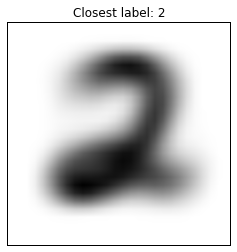

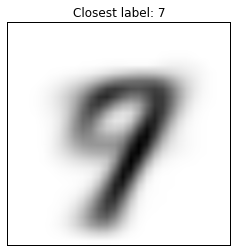

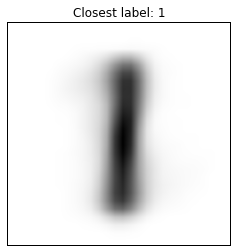

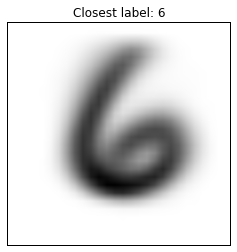

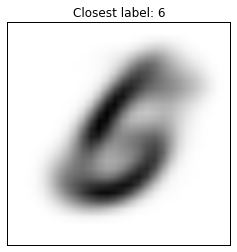

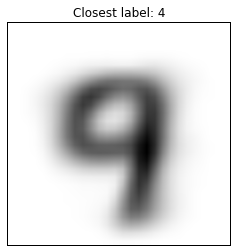

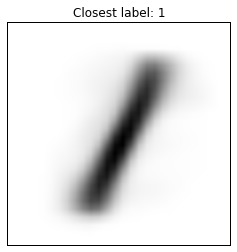

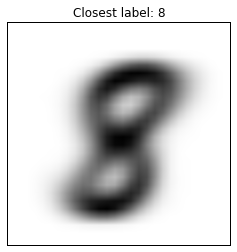

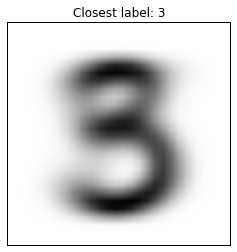

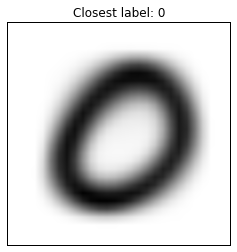

In [164]:
# visualize cluster centers and compare with closest label
for i in range(10):
    image = clusters.centers[i]
    image = image.astype(float)/256
    plt.figure(i)
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title('Closest label: %d' % clusterLabels[i])

In [123]:
errorRate = 1 - digits_dev.map(lambda x: clusterLabels[clusters.predict(x[1])] == x[0]).mean()
print 'Error rate for %d clusters: %.2f%%' % (K, errorRate * 100)

Error rate for 10 clusters: 40.58%


In [171]:
# Compute test error for a range of K
rates = []
for k in range(5, 81):
    #print 'Computing for K = %d...' % k
    clusters = KMeans.train(digits_train.map(lambda x: x[1]), k, maxIterations = 50, runs = 5, initializationMode = "random")
    clusterLabels = asscLabels(clusters)
    rates.append(1 - digits_dev.map(lambda x: clusterLabels[clusters.predict(x[1])] == x[0]).mean())
    #print 'Error rate for K = %d: %.2f%%' % (k, rates[-1] * 100)

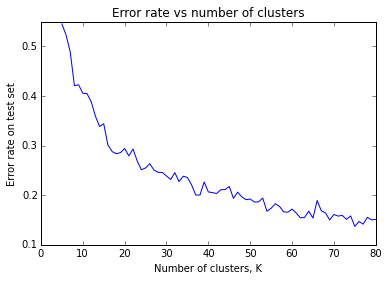

In [128]:
plt.plot(range(5, 81), rates)
plt.xlabel('Number of clusters, K')
plt.ylabel('Error rate on test set')
plt.title('Error rate vs number of clusters')

In [18]:
# It appears that misclassification errors decrease monotonically with K
# Let's try even larger values
rates2 = []
for k in range(1, 8):
    #print 'Computing for K = %d...' % (k*100)
    clusters = KMeans.train(digits_train.map(lambda x: x[1]), k * 100, maxIterations = 50, runs = 5, initializationMode = "random")
    clusterLabels = asscLabels(clusters)
    rates2.append(1 - digits_dev.map(lambda x: clusterLabels[clusters.predict(x[1])] == x[0]).mean())
    #print 'Error rate for K = %d: %.2f%%' % (k*100, rates2[-1] * 100)

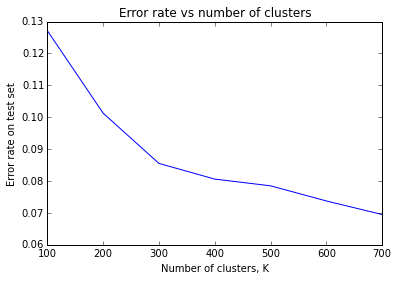

In [19]:
plt.plot([x * 100 for x in range(1, 8)], rates2)
plt.xlabel('Number of clusters, K')
plt.ylabel('Error rate on test set')
plt.title('Error rate vs number of clusters')

In [4]:
print 'Computing for K = %d...' % 1000
clusters = KMeans.train(digits_train.map(lambda x: x[1]), 1000, maxIterations = 50, runs = 5, initializationMode = "random")
clusterLabels = asscLabels(clusters)
print 'Error rate for K = %d: %.2f%%' % (1000, (1 - digits_dev.map(lambda x: clusterLabels[clusters.predict(x[1])] == x[0]).mean()) * 100)

Computing for K = 1000...
Error rate for K = 1000: 6.07%


In [20]:
# hmm... the error rate is smaller again for such a large K
# however that doesn't mean larger is better!
# take K = size of training set; ie. classify a digit to the closest point in the training set
# here is a demonstration that this isn't any good

from operator import itemgetter
def findClosest(img):
    #return digits_train.map(lambda x: (x[0], sum((x[1] - img[1]) ** 2), x[1]))
    return digits_train.map(lambda x: (x[0], sum((x[1] - img[1]) ** 2), x[1])).min(itemgetter(1))
testsize = 5
correct = 0
test = digits_dev.take(testsize)
for i in test:
    best = findClosest(i)
    print "predicted %d from %d" % (best[0], i[0])
    #print "d = %.3f" % (best[1])
    correct += best == i[0]

predicted 1 from 0
predicted 7 from 4
predicted 5 from 2
predicted 4 from 5
predicted 2 from 6


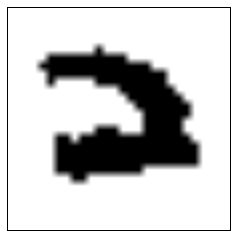

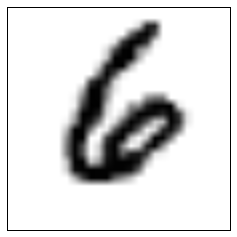

In [21]:
plt.figure(0)
image = best[2]
image = image.astype(float)/256
fig = plt.imshow(image.reshape(28,28))
fig.set_cmap('gray_r')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.figure(1)
image = i[1]
image = image.astype(float)/256
fig = plt.imshow(image.reshape(28,28))
fig.set_cmap('gray_r')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

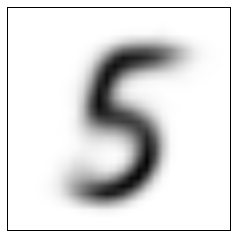

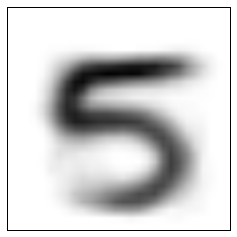

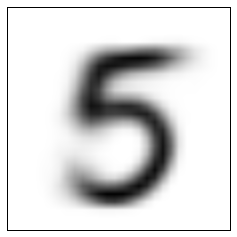

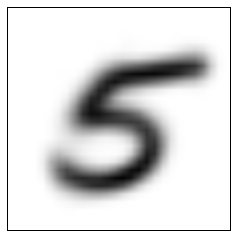

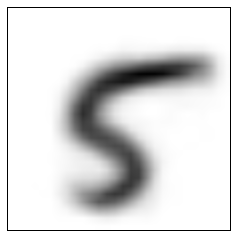

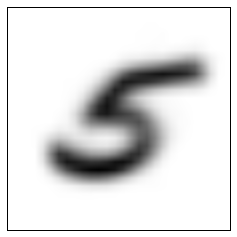

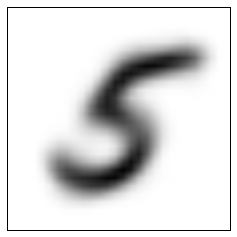

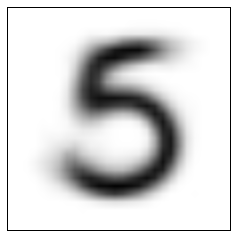

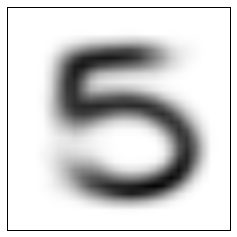

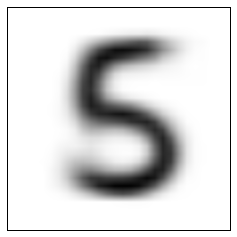

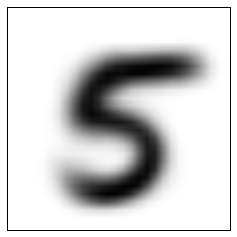

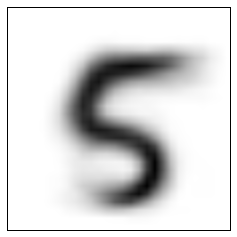

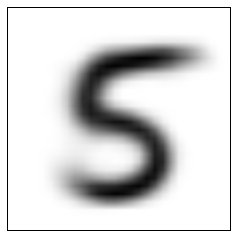

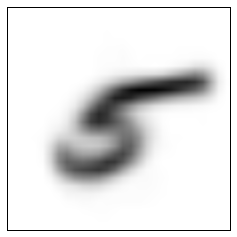

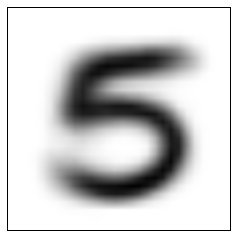

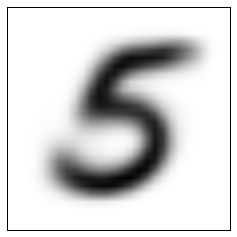

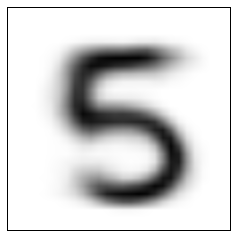

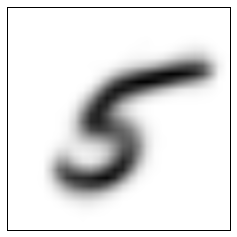

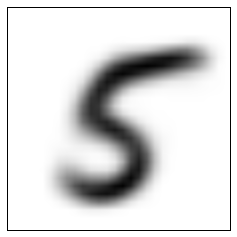

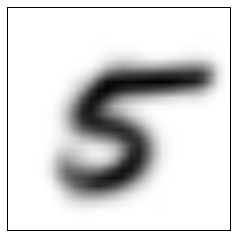

In [73]:
# We now turn to supervised learning

cl = 20 # number of clusters per label
tcl = KMeans.train(digits_train.filter(lambda x: x[0] == 5).map(lambda x: x[1]), cl, maxIterations = 50, runs = 5, initializationMode = "random")
# have a look at the centers for 5
for i in range(cl):
    image = tcl.centers[i]
    image = image.astype(float)/256
    plt.figure(i)
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
# the centers capture various "classes" of 5

In [74]:
# now find all clusters
cls = [] # stores the 10 KMeans.train objects
for i in range(10):
    obj = KMeans.train(digits_train.filter(lambda x: x[0] == i).map(lambda x: x[1]), cl, maxIterations = 50, runs = 5, initializationMode = "random")
    cls.append(obj)

In [75]:
# find error rate on test set
def isCorrect(x): # map job on test set
    mindist = float("inf")
    lab = -1
    for i in range(10): # for each label
        for j in range(cl): # for each centroid in that label
            dist = sum((cls[i].centers[j] - x[1]) ** 2)
            if dist < mindist:
                mindist = dist
                lab = i
    return x[0] == lab
print 'Error rate: %.2f%%' % ((1 - digits_dev.map(isCorrect).reduce(lambda x, y: x + y) / digits_dev.count()) * 100)

Error rate: 6.52%
